Epoch 1/5
157/157 [==============================] - 1s 2ms/step - loss: 0.5999 - accuracy: 0.8308 - val_loss: 0.3510 - val_accuracy: 0.8960
Epoch 2/5
157/157 [==============================] - 0s 2ms/step - loss: 0.2552 - accuracy: 0.9296 - val_loss: 0.2752 - val_accuracy: 0.9200
Epoch 3/5
157/157 [==============================] - 0s 2ms/step - loss: 0.1868 - accuracy: 0.9476 - val_loss: 0.2594 - val_accuracy: 0.9220
Epoch 4/5
157/157 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9664 - val_loss: 0.2128 - val_accuracy: 0.9340
Epoch 5/5
157/157 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9788 - val_loss: 0.2165 - val_accuracy: 0.9280
Epoch 1/5
79/79 [==============================] - 439s 6s/step - loss: 1.1695 - accuracy: 0.7974 - val_loss: 0.1223 - val_accuracy: 0.9620
Epoch 2/5
79/79 [==============================] - 451s 6s/step - loss: 0.0802 - accuracy: 0.9796 - val_loss: 0.0793 - val_accuracy: 0.9800
Epoch 3/5
79/79

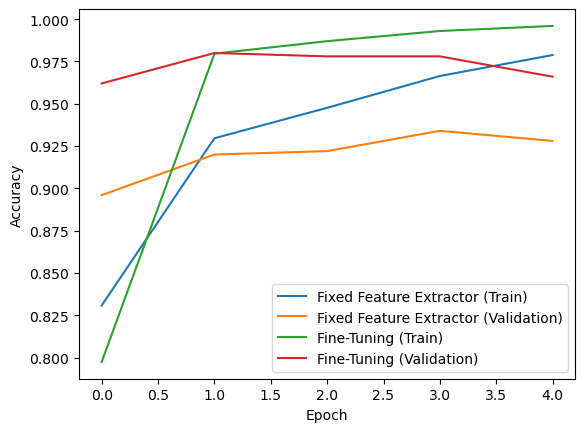

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG19
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Load a subset of the dataset (5000 training images and 500 testing images)
X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_test[:500]
y_test = y_test[:500]

X_train_froz, X_test_froz = X_train / 255.0, X_test / 255.0
y_train_froz, y_test_froz = to_categorical(y_train), to_categorical(y_test)

# Load VGG19 pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Fixed feature extractor approach
model_frozen = Sequential()
model_frozen.add(Flatten(input_shape=X_train.shape[1:]))
model_frozen.add(Dense(256, activation='relu'))
model_frozen.add(Dense(10, activation='softmax'))

model_frozen.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the frozen model
history_frozen = model_frozen.fit(X_train_froz, y_train_froz, epochs=5, batch_size=32, validation_data=(X_test_froz, y_test_froz))

#  Convert grayscale images to RGB (VGG requires 3 channels)
X_train_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_train, axis=-1))
X_test_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_test, axis=-1))

# Resize images to match VGG input size (224x224)
X_train_resized = tf.image.resize(X_train_rgb, (224, 224))
X_test_resized = tf.image.resize(X_test_rgb, (224, 224))

# Normalize pixel values to [0, 1]
X_train_resized = X_train_resized / 255.0
X_test_resized = X_test_resized / 255.0

# Convert labels to one-hot encoding
y_train_rgb = to_categorical(y_train, num_classes=10)
y_test_rgb = to_categorical(y_test, num_classes=10)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_finetuned = Model(inputs=base_model.input, outputs=output) # Create the fine-tuned model

# Freeze the layers of the base VGG model
for layer in base_model.layers:
    layer.trainable = False

model_finetuned.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_finetuned = model_finetuned.fit(X_train_resized, y_train_rgb, batch_size=64, epochs=5, validation_data=(X_test_resized, y_test_rgb))

# Evaluate the model
loss, accuracy = model_finetuned.evaluate(X_test_resized, y_test_rgb)
print("Test accuracy:", accuracy)

plt.plot(history_frozen.history['accuracy'], label='Fixed Feature Extractor (Train)')
plt.plot(history_frozen.history['val_accuracy'], label='Fixed Feature Extractor (Validation)')
plt.plot(history_finetuned.history['accuracy'], label='Fine-Tuning (Train)')
plt.plot(history_finetuned.history['val_accuracy'], label='Fine-Tuning (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
